___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Session - 10 Part -1<br><br>Univariate Time Series Forecasting with RNN<br><br>RSCCASN<br><h1>

# RNN (Time Series)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [3]:
df = pd.read_csv('./RSCCASN.csv',
                 index_col='DATE',
                 parse_dates=True
                )

In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [6]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

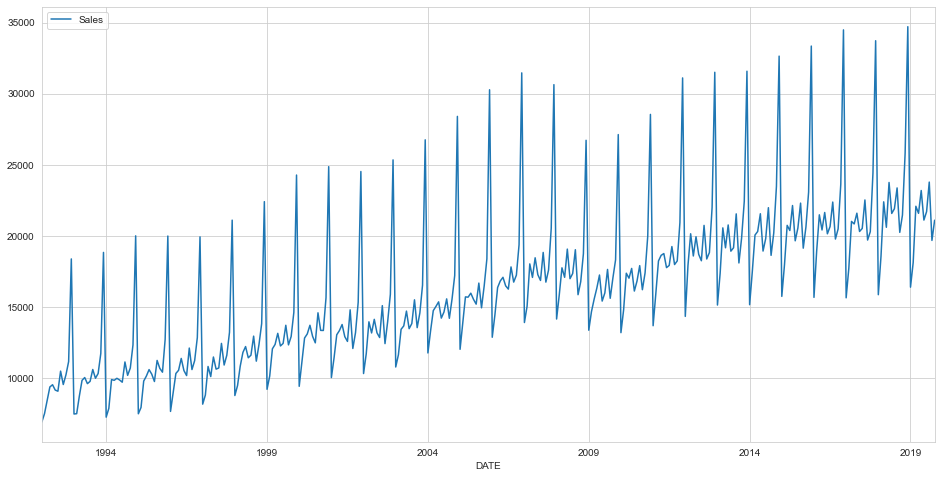

In [7]:
df.plot(figsize=(16,8))

## Preprocessing of Data

### Train Test Split

In [8]:
len(df)

334

In [9]:
test_size = 24

In [10]:
test_ind = len(df)- test_size
test_ind

310

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-06-01,20322
2017-07-01,20535
2017-08-01,22536


In [13]:
test

,Sales
DATE,
2017-11-01,24438
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919


### Scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
# help(TimeseriesGenerator)

In [19]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [20]:
len(generator)

298

In [21]:
generator[0]

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [22]:
X, y = generator[0]

In [23]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


## Modelling

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [25]:
n_features = train_scaled.shape[1]

In [26]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [29]:
# params = 4 * ((size_of_input + 1) * size_of_output + size_of_output^2)
4 * ((1+1)*100+(100**2))

40800

In [30]:
4 * ((100+1)*50+(50**2))

30200

### EarlyStopping and Validation Generator

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [33]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [34]:
len(validation_generator)

12

In [35]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
298/298 [==============================] - 10s 15ms/step - loss: 0.0227 - val_loss: 0.0291
Epoch 2/20
298/298 [==============================] - 3s 11ms/step - loss: 0.0192 - val_loss: 0.0290
Epoch 3/20
298/298 [==============================] - 5s 16ms/step - loss: 0.0178 - val_loss: 0.0248
Epoch 4/20
298/298 [==============================] - 4s 13ms/step - loss: 0.0168 - val_loss: 0.0253
Epoch 5/20
298/298 [==============================] - 3s 10ms/step - loss: 0.0164 - val_loss: 0.0305
Epoch 6/20
298/298 [==============================] - 3s 11ms/step - loss: 0.0159 - val_loss: 0.0255
Epoch 7/20
298/298 [==============================] - 3s 10ms/step - loss: 0.0154 - val_loss: 0.0206
Epoch 8/20
298/298 [==============================] - 3s 11ms/step - loss: 0.0153 - val_loss: 0.0205
Epoch 9/20
298/298 [==============================] - 4s 12ms/step - loss: 0.0136 - val_loss: 0.0182
Epoch 10/20
298/298 [==============================] - 3s 11ms/step - loss: 0.0131 - val_l

<AxesSubplot:>

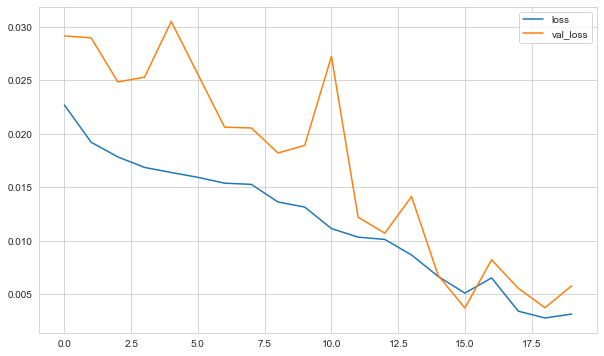

In [36]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

## Evaluate on Test Data

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [38]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [39]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [40]:
predictions_scaled

[array([0.58957326], dtype=float32),
 array([0.79855376], dtype=float32),
 array([0.38704747], dtype=float32),
 array([0.45999885], dtype=float32),
 array([0.5338818], dtype=float32),
 array([0.53190964], dtype=float32),
 array([0.5416708], dtype=float32),
 array([0.51174486], dtype=float32),
 array([0.52296114], dtype=float32),
 array([0.54715645], dtype=float32),
 array([0.47590956], dtype=float32),
 array([0.49828145], dtype=float32)]

In [41]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.8170705131785666 
mae: 0.04827559315139207 
mse: 0.0040514171708564365 
rmse: 0.06365074367873824


### Inverse Transformations and Comparing

In [48]:
predictions = scaler.inverse_transform(predictions_scaled)

In [49]:
compare = test[:12]

In [50]:
compare['Predictions'] = predictions

In [51]:
compare

,Sales,Predictions
DATE,,
2017-11-01,24438,23177.206
2017-12-01,33720,28933.365
2018-01-01,15881,17598.836
2018-02-01,18585,19608.208
2018-03-01,22404,21643.240
2018-04-01,20616,21588.919
2018-05-01,23764,21857.780
2018-06-01,21589,21033.500
2018-07-01,21919,21342.442


<AxesSubplot:xlabel='DATE'>

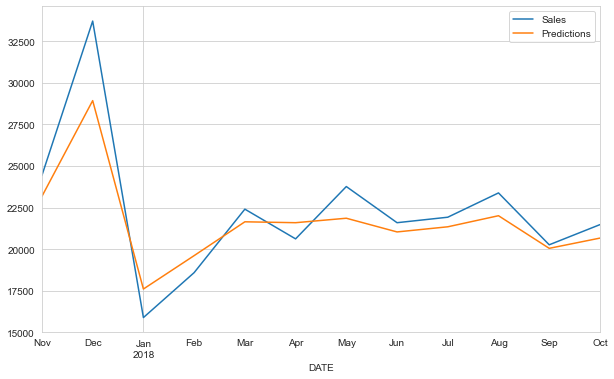

In [52]:
compare.plot()

In [53]:
eval_metrics(compare.Sales, compare.Predictions)

r2_score: 0.8170705131785664 
mae: 1329.7029377619444 
mse: 3073696.5085572978 
rmse: 1753.1960838871669


## Retrain and Forecasting

In [54]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [55]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [56]:
len(df)

334

In [57]:
len(generator)

322

In [58]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
322/322 [==============================] - 8s 11ms/step - loss: 0.0217
Epoch 2/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0198
Epoch 3/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0180
Epoch 4/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0177
Epoch 5/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0169
Epoch 6/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0165
Epoch 7/15
322/322 [==============================] - 5s 15ms/step - loss: 0.0144
Epoch 8/15
322/322 [==============================] - 5s 15ms/step - loss: 0.0134
Epoch 9/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0137
Epoch 10/15
322/322 [==============================] - 4s 11ms/step - loss: 0.0132
Epoch 11/15
322/322 [==============================] - 4s 12ms/step - loss: 0.0101
Epoch 12/15
322/322 [==============================] - 4s 12ms/step - loss: 0.0071
Epoch 13/15
3

In [59]:
scaled_full_data.shape

(334, 1)

In [60]:
scaled_full_data[-length:].shape

(12, 1)

In [61]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [62]:
forecast = scaler.inverse_transform(forecast)

In [63]:
forecast

array([[26126.98642588],
       [29342.21819305],
       [18449.35001063],
       [20147.76946354],
       [22362.58588791],
       [22214.27344608],
       [22648.24552107],
       [21431.58703279],
       [21789.06010914],
       [22068.30378199],
       [20472.76461387],
       [22334.91582775]])

In [64]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [65]:
forecast_index = pd.date_range(start = '2019-11-01', periods = length, freq = 'MS')

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [66]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [67]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [68]:
forecast_df

,Forecast
2019-11-01,26126.986
2019-12-01,29342.218
2020-01-01,18449.350
2020-02-01,20147.769
2020-03-01,22362.586
2020-04-01,22214.273
2020-05-01,22648.246
2020-06-01,21431.587
2020-07-01,21789.060
2020-08-01,22068.304


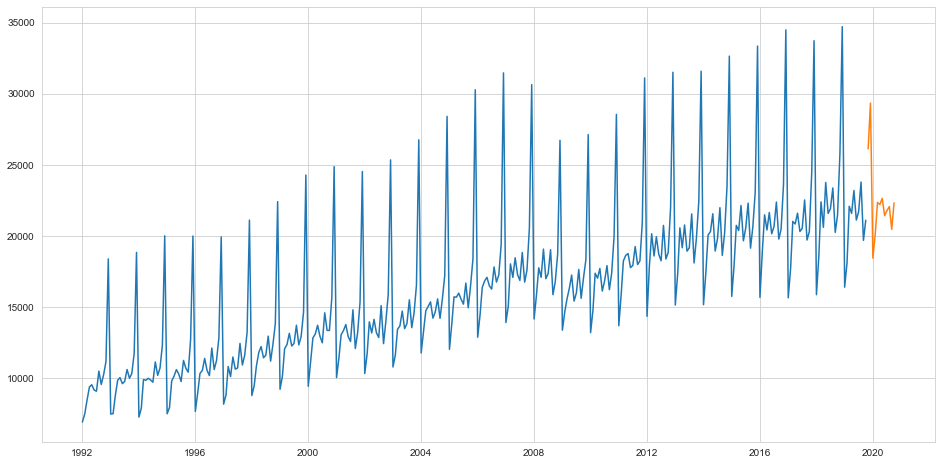

In [69]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

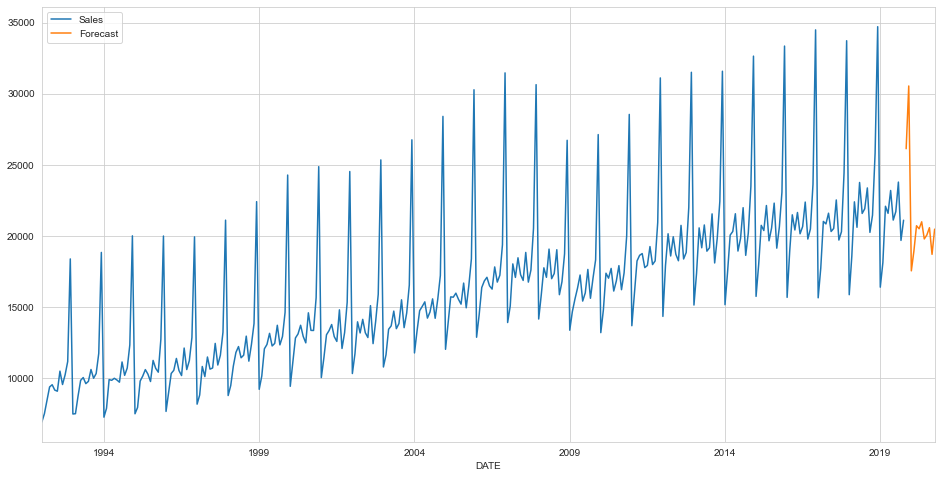

In [62]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 611.0)

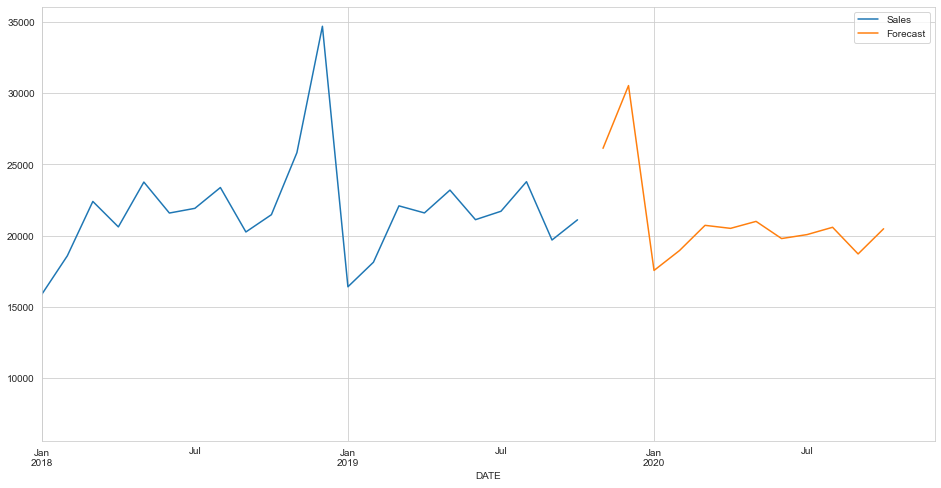

In [63]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___